### Etymology Prefix Suffix Analysis

In [ ]:
import pandas as pd
import numpy as np
import glob
import re

In [ ]:
# language pair
lang_folder = "Turkish"  # Arabic, English, French, German, Turkish, Spanish, Portuguese, Dutch, Italian ==> target language for learner
lang_pair = "English"  # Arabic, English, French, German, Turkish, Spanish, Portuguese, Dutch, Italian ==> native language

#### Nişanyan

In [ ]:
df_word_plus_nisanyan = pd.read_excel("/media/kurubal/SSD/Data Scientist/Work/Modern Ways/Project/Web Scrapping/Data/All/Nisanyan Words Contain Plus.xlsx")
df_word_plus_nisanyan

In [ ]:
def remove(x):
    try:
        x = x.replace("\n","")
        x = x.replace("\r","")
        x = x.strip()
    except:
        x = x
    return x

In [ ]:
df_word_plus_nisanyan["term"] = df_word_plus_nisanyan["term"].apply(lambda x: remove(x))
df_word_plus_nisanyan["related_lang"] = df_word_plus_nisanyan["related_lang"].apply(lambda x: remove(x))
df_word_plus_nisanyan["related_term"] = df_word_plus_nisanyan["related_term"].apply(lambda x: remove(x))
df_word_plus_nisanyan

In [ ]:
df_word = pd.read_excel(f"/media/kurubal/SSD/Data Scientist/Work/Modern Ways/Project/Turkish/Result/Word/Merge/Word_Merge2.xlsx")
#df_word = df_word.head(10000)
df_word

In [ ]:
disable_term_list = ["+ark","+gen","+gon","di+","+men","deka+","desi+","bis+","end(o)+","fil(o)+","mili+","ö+","or(o)+","pan(to)+","poli+","port+","post+","vaz(o)+"]

In [ ]:
set_plus_term = set(df_word_plus_nisanyan.loc[:,"term"].values.tolist())
set_disable_term = set(disable_term_list)

In [ ]:
df_term_diff = pd.DataFrame(set_plus_term.difference(set_disable_term), columns=["term"])
df_term_diff

In [ ]:
word_list = df_term_diff.loc[:,"term"].values.tolist()

In [ ]:
df_word_result = pd.DataFrame()
for i in word_list:
    if i.startswith("+"):
        j = i.lstrip("+")
        word_in_video = df_word[df_word.word.str.contains(fr"{j}(?:$)", na=True)]  # string+ext=> word
        word_in_video.insert(0,"term",i)
    elif i.endswith("+"):
        j = i.rstrip("+")
        word_in_video = df_word[df_word.word.str.contains(fr"(?:^){j}", na=True)]  # ext+string=> word
        word_in_video.insert(0,"term",i)
    else:
        pass
    #word_in_video.insert(0,"word_ext",i)
    df_word_result = pd.concat([df_word_result,word_in_video], axis=0)
#df_word_result = df_word_result.sort_values(by="frequency", ascending=False)
df_word_result.reset_index(drop=True, inplace=True)
df_word_result   

In [ ]:
df_pre_suff_nis_merge = pd.merge(df_word_result,df_word_plus_nisanyan, how="inner", on="term")
df_pre_suff_nis_merge

In [ ]:
df_pre_suff_nis_merge.word.nunique()

In [ ]:
df_pre_suff_nis_merge.to_excel("Nisanyan_Prefix_Suffix_Term_In_Word.xlsx", index=False)

##### SparkNLP Lemma

In [ ]:
df_spark_lemma = pd.read_json("/media/kurubal/SSD/Data Scientist/Work/Modern Ways/Project/Web Scrapping/Data/All/wR3tE0i-zc6Pl8revsMq4.json")  # lemma result
df_spark_lemma = df_spark_lemma.loc[:,["lem","token"]]
df_spark_lemma.rename(columns={"token":"word"}, inplace=True)
df_spark_lemma

In [ ]:
df_spark_lemma.lem.nunique()

In [ ]:
df_pre_suff_nis_merge = pd.read_excel("Nisanyan_Prefix_Suffix_Term_In_Word.xlsx")
df_pre_suff_nis_merge

In [ ]:
df_lemma_merge = pd.merge(df_pre_suff_nis_merge,df_spark_lemma, how="inner", on="word")
df_lemma_merge.drop_duplicates(inplace=True)
df_lemma_merge

In [ ]:
df_lemma_merge.drop_duplicates(subset="lem", inplace=True)
df_lemma_merge.reset_index(drop=True, inplace=True)
df_lemma_merge

In [ ]:
df_lemma_merge.to_excel("Nisanyan_Prefix_Suffix_Term_In_Word_Lemma_Process.xlsx", index=False)

#### Etymology Word Prefix Suffix Analysis

In [9]:
import os
import pandas as pd
import numpy as np
import glob
import re
from kneed import KneeLocator
from pathlib import Path
import shutil

In [10]:
# language pair
lang_folder = "Turkish"  # Arabic, English, French, German, Turkish, Spanish, Portuguese, Dutch, Italian ==> target language for learner
lang_pair = "English"  # Arabic, English, French, German, Turkish, Spanish, Portuguese, Dutch, Italian ==> native language

# pre-suffix select
prefix = True  # True, False  word is prefix  example: prefix = True and suffix = False for Turkish word
suffix = False # True, False  word is suffix

# native word select
word_analysis = True  # True, False  Not: True for native word analysis, False for etymological word analysis
word_num = 28

In [11]:
Path(f"/media/kurubal/SSD/Data Scientist/Work/Modern Ways/Project/Web Scrapping/Data/{lang_folder.capitalize()}").mkdir(parents=True, exist_ok=True)
Path(f"/media/kurubal/SSD/Data Scientist/Work/Modern Ways/Project/Web Scrapping/Result/{lang_folder.capitalize()}").mkdir(parents=True, exist_ok=True)

In [39]:
def detect_prefix_suffix_word(df, df_column, word_ety_list, prefix_word=True, suffix_word=False):
    '''
    default parameter:\n
    detect_prefix_suffix_word(df, df_column, word_ety_list, prefix_word=True, suffix_word=False)\n
    detect_prefix_suffix_word(df, "word", ["abacus","aba","su"], prefix=True, suffix=True)\n
    df is dataframe. Each word of word_ety_list search in df_column according to prefix_word and suffix_word condition.\n
    prefix_word and suffix_word are not extention. they represents location of word of word_ety_list (word before or after)
    '''    
    df_ety_prefix_suffix_word_result = pd.DataFrame()
    for i in word_ety_list:
        # suffix result
        if suffix_word:
            word_ety_in_word = df[df[f"{df_column}"].str.contains(fr"{i}(?:$)", na=True)]  # string+ext=> word
            word_ety_in_word.insert(0,"search_word",i)
            df_ety_prefix_suffix_word_result = pd.concat([df_ety_prefix_suffix_word_result,word_ety_in_word], axis=0)
        else:
            pass
        # prefix result
        if prefix_word:
            word_ety_in_word = df[df[f"{df_column}"].str.contains(fr"(?:^){i}", na=True)]  # ext+string=> word
            word_ety_in_word.insert(0,"search_word",i)
            df_ety_prefix_suffix_word_result = pd.concat([df_ety_prefix_suffix_word_result,word_ety_in_word], axis=0)
        else:
            pass    
        
    #df_ety_suffix_word_result = df_word_result.sort_values(by="frequency", ascending=False)
    df_ety_prefix_suffix_word_result.drop_duplicates(inplace=True)
    df_ety_prefix_suffix_word_result.reset_index(drop=True, inplace=True)

    return df_ety_prefix_suffix_word_result 

In [40]:
def exract_prefix_suffix(df, source_column, target_column):
    '''
    exract_prefix_suffix(df, source_column, target_column):\n
    exract_prefix_suffix(df, "word_pair", "word"):\n
    df is dataframe. word of source_column search in target_column\n
    and exract prefix or suffix. 
    '''
    for i in range(len(df)):
        source_word = df.loc[i,f"{source_column}"]
        target_word = df.loc[i,f"{target_column}"]
        try:
            search_loc = re.search(fr"{source_word}", target_word, re.UNICODE|re.IGNORECASE)
            search_loc_start = search_loc.span()[0]
            search_loc_end = search_loc.span()[1]
            if search_loc_start > 0:
                var1= target_word[0:search_loc_start]
                prefix_suffix = f"{var1}+"
                df.loc[i,"prefix_suffix"] = prefix_suffix                
            else:
                var2 = target_word[search_loc_end:]
                prefix_suffix = f"+{var2}" 
                df.loc[i,"prefix_suffix"] = prefix_suffix 
        except:
            pass
    return df

##### Prefix Suffix All

In [41]:
df_word_all = pd.read_excel(f"/media/kurubal/SSD/Data Scientist/Work/Modern Ways/Project/{lang_folder.lower().capitalize()}/Deployment/Data/Word/Word_Merge_Preprocess.xlsx")
df_word_all

,word,frequency
0,bir,18835735
1,bu,11062659
2,ne,8025880
3,ve,7766036
4,için,5484109
...,...,...
1005970,karnaya,5
1005971,dörtlümüzün,5
1005972,karnavalınız,5
1005973,hurmanın,5


In [42]:
if word_analysis:
    df_pair = pd.read_excel(f"/media/kurubal/SSD/Data Scientist/Work/Modern Ways/Project/{lang_folder.lower().capitalize()}/Deployment/Data/Word/Word_Merge_Preprocess.xlsx")
    df_pair = df_pair.head(word_num)
    df_pair.rename(columns={"word":"dict_entry_main"}, inplace=True)
else:
    df_pair = pd.read_excel(f"/media/kurubal/SSD/Data Scientist/Work/Modern Ways/Project/Web Scrapping/Result/{lang_folder.capitalize()}/{lang_folder.capitalize()}_{lang_pair.lower().capitalize()}_Shared_Vocabulary.xlsx")
df_pair

,dict_entry_main,frequency
0,bir,18835735
1,bu,11062659
2,ne,8025880
3,ve,7766036
4,için,5484109
5,mi,5362714
6,o,5013838
7,ben,4908913
8,de,4880315
9,çok,4852169


In [43]:
word_ety_list = df_pair["dict_entry_main"].values.tolist()
#word_ety_list

In [44]:
df_prefix_suffix_word = detect_prefix_suffix_word(df_word_all, "word", word_ety_list, prefix_word=prefix, suffix_word=suffix)
df_prefix_suffix_word

,search_word,word,frequency
0,bir,bir,18835735
1,bir,biraz,1269641
2,bir,biri,837400
3,bir,birlikte,409940
4,bir,birkaç,404462
...,...,...,...
87687,gibi,gibiysek,5
87688,gibi,gibisaçmalayıp,5
87689,gibi,gibitüyleriniyolacağız,5
87690,gibi,gibisadece,5


In [45]:
df_prefix_suffix = exract_prefix_suffix(df_prefix_suffix_word, "search_word", "word")
df_prefix_suffix

,search_word,word,frequency,prefix_suffix
0,bir,bir,18835735,+
1,bir,biraz,1269641,+az
2,bir,biri,837400,+i
3,bir,birlikte,409940,+likte
4,bir,birkaç,404462,+kaç
...,...,...,...,...
87687,gibi,gibiysek,5,+ysek
87688,gibi,gibisaçmalayıp,5,+saçmalayıp
87689,gibi,gibitüyleriniyolacağız,5,+tüyleriniyolacağız
87690,gibi,gibisadece,5,+sadece


In [46]:
df_prefix_suffix.search_word.nunique()

28

In [47]:
df_prefix_suffix.word.nunique()

85852

In [48]:
if word_analysis:
    df_prefix_suffix.to_excel(f"{lang_folder.capitalize()}_{lang_pair.capitalize()}_{word_num}_Word_Prefix_Suffix_All.xlsx", index=False)
else:
    df_prefix_suffix.to_excel(f"{lang_folder.capitalize()}_{lang_pair.capitalize()}_Shared_Word_Prefix_Suffix_All.xlsx", index=False)

##### Select From Length

In [49]:
if word_analysis:
    df_prefix_suffix = pd.read_excel(f"{lang_folder.capitalize()}_{lang_pair.capitalize()}_{word_num}_Word_Prefix_Suffix_All.xlsx")
else:
    df_prefix_suffix = pd.read_excel(f"{lang_folder.capitalize()}_{lang_pair.capitalize()}_Shared_Word_Prefix_Suffix_All.xlsx")
df_prefix_suffix

,search_word,word,frequency,prefix_suffix
0,bir,bir,18835735,+
1,bir,biraz,1269641,+az
2,bir,biri,837400,+i
3,bir,birlikte,409940,+likte
4,bir,birkaç,404462,+kaç
...,...,...,...,...
87687,gibi,gibiysek,5,+ysek
87688,gibi,gibisaçmalayıp,5,+saçmalayıp
87689,gibi,gibitüyleriniyolacağız,5,+tüyleriniyolacağız
87690,gibi,gibisadece,5,+sadece


In [50]:
df_prefix_suffix["prefix_suffix_len"] = df_prefix_suffix["prefix_suffix"].apply(lambda x: (len(x)-1))
df_prefix_suffix

,search_word,word,frequency,prefix_suffix,prefix_suffix_len
0,bir,bir,18835735,+,0
1,bir,biraz,1269641,+az,2
2,bir,biri,837400,+i,1
3,bir,birlikte,409940,+likte,5
4,bir,birkaç,404462,+kaç,3
...,...,...,...,...,...
87687,gibi,gibiysek,5,+ysek,4
87688,gibi,gibisaçmalayıp,5,+saçmalayıp,10
87689,gibi,gibitüyleriniyolacağız,5,+tüyleriniyolacağız,18
87690,gibi,gibisadece,5,+sadece,6


In [51]:
prefix_suffix_mean = int(round(df_prefix_suffix["prefix_suffix_len"].mean(),0))
prefix_suffix_mean

8

In [52]:
df_prefix_suffix_select = df_prefix_suffix[df_prefix_suffix["prefix_suffix"].str.len() <= prefix_suffix_mean]
df_prefix_suffix_select

,search_word,word,frequency,prefix_suffix,prefix_suffix_len
0,bir,bir,18835735,+,0
1,bir,biraz,1269641,+az,2
2,bir,biri,837400,+i,1
3,bir,birlikte,409940,+likte,5
4,bir,birkaç,404462,+kaç,3
...,...,...,...,...,...
87684,gibi,gibiyeah,5,+yeah,4
87685,gibi,gibiyidim,5,+yidim,5
87687,gibi,gibiysek,5,+ysek,4
87690,gibi,gibisadece,5,+sadece,6


In [53]:
if word_analysis:
    df_prefix_suffix_select.to_excel(f"{lang_folder.capitalize()}_{lang_pair.capitalize()}_{word_num}_Word_Prefix_Suffix_Select.xlsx", index=False)
else:
    df_prefix_suffix_select.to_excel(f"{lang_folder.capitalize()}_{lang_pair.capitalize()}_Shared_Word_Prefix_Suffix_Select.xlsx", index=False)

##### Select With Prefix Suffix

In [54]:
if word_analysis:
    df_prefix_suffix_select = pd.read_excel(f"{lang_folder.capitalize()}_{lang_pair.capitalize()}_{word_num}_Word_Prefix_Suffix_Select.xlsx")
else:
    df_prefix_suffix_select = pd.read_excel(f"{lang_folder.capitalize()}_{lang_pair.capitalize()}_Shared_Word_Prefix_Suffix_Select.xlsx")
df_prefix_suffix_select

,search_word,word,frequency,prefix_suffix,prefix_suffix_len
0,bir,bir,18835735,+,0
1,bir,biraz,1269641,+az,2
2,bir,biri,837400,+i,1
3,bir,birlikte,409940,+likte,5
4,bir,birkaç,404462,+kaç,3
...,...,...,...,...,...
44027,gibi,gibiyeah,5,+yeah,4
44028,gibi,gibiyidim,5,+yidim,5
44029,gibi,gibiysek,5,+ysek,4
44030,gibi,gibisadece,5,+sadece,6


In [55]:
df_prefix_suffix_freq = df_prefix_suffix_select[["prefix_suffix"]].value_counts().reset_index()
df_prefix_suffix_freq.rename(columns={0:"frequency"}, inplace=True)
df_prefix_suffix_freq

,prefix_suffix,frequency
0,+,99
1,+i,35
2,+n,27
3,+o,26
4,+l,26
...,...,...
35128,+lgıçtı,1
35129,+lgıçmış,1
35130,+lgıçlık,1
35131,+lgıçlar,1


In [56]:
prefix_suffix_freq_sum = df_prefix_suffix_freq.loc[:,"frequency"].sum()
prefix_suffix_freq_sum

44032

In [57]:
df_prefix_suffix_freq["ratio"] = round(((df_prefix_suffix_freq.loc[:,"frequency"]/prefix_suffix_freq_sum)*100),7)
df_prefix_suffix_freq


,prefix_suffix,frequency,ratio
0,+,99,0.224836
1,+i,35,0.079488
2,+n,27,0.061319
3,+o,26,0.059048
4,+l,26,0.059048
...,...,...,...
35128,+lgıçtı,1,0.002271
35129,+lgıçmış,1,0.002271
35130,+lgıçlık,1,0.002271
35131,+lgıçlar,1,0.002271


In [58]:
df_prefix_suffix_freq["cumul_ratio"] = np.cumsum(df_prefix_suffix_freq["ratio"])
df_prefix_suffix_freq

,prefix_suffix,frequency,ratio,cumul_ratio
0,+,99,0.224836,0.224836
1,+i,35,0.079488,0.304324
2,+n,27,0.061319,0.365643
3,+o,26,0.059048,0.424691
4,+l,26,0.059048,0.483739
...,...,...,...,...
35128,+lgıçtı,1,0.002271,99.991793
35129,+lgıçmış,1,0.002271,99.994064
35130,+lgıçlık,1,0.002271,99.996335
35131,+lgıçlar,1,0.002271,99.998607


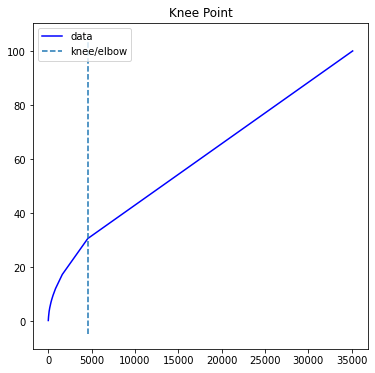

In [59]:
prefix_suffix_kneedle = KneeLocator(x=df_prefix_suffix_freq.cumul_ratio.index, y=df_prefix_suffix_freq.cumul_ratio, S=1.0, curve="concave", direction="increasing")
prefix_suffix_kneedle.plot_knee()

In [60]:
knee_point_prefix_suffix = round(prefix_suffix_kneedle.knee_y)
knee_point_prefix_suffix

31

In [61]:
df_prefix_suffix_knee = df_prefix_suffix_freq[df_prefix_suffix_freq.cumul_ratio <= knee_point_prefix_suffix]
df_prefix_suffix_knee

,prefix_suffix,frequency,ratio,cumul_ratio
0,+,99,0.224836,0.224836
1,+i,35,0.079488,0.304324
2,+n,27,0.061319,0.365643
3,+o,26,0.059048,0.424691
4,+l,26,0.059048,0.483739
...,...,...,...,...
4745,+rpelson,1,0.002271,30.988962
4746,+ntnor,1,0.002271,30.991233
4747,+ntoine,1,0.002271,30.993504
4748,+rrik,1,0.002271,30.995775


In [63]:
prefix_suffix_list = df_prefix_suffix_knee["prefix_suffix"].to_list()

In [64]:
disable_prefix_suffix_list = ["+anityi","+bidir","+workun","+düktörlere","+rysin","+ein","+ei","+x","+ren","+hul"]

In [65]:
set_prefix_suffix = set(prefix_suffix_list)
set_disable_prefix_suffix = set(disable_prefix_suffix_list)

In [66]:
prefix_suffix_custom_list = list(set_prefix_suffix.difference(set_disable_prefix_suffix))

In [67]:
df_prefix_suffix_custom = pd.DataFrame()
for i in prefix_suffix_custom_list:
    df_var = df_prefix_suffix[df_prefix_suffix["prefix_suffix"] == f"{i}"]
    df_prefix_suffix_custom = pd.concat([df_prefix_suffix_custom, df_var], axis=0)
df_prefix_suffix_custom.sort_values(by="word", inplace=True)
df_prefix_suffix_custom.reset_index(drop=True, inplace=True)
df_prefix_suffix_custom

,search_word,word,frequency,prefix_suffix,prefix_suffix_len
0,ama,ama,4661966,+,0
1,ama,ama,5,+,0
2,ama,ama,10,+,0
3,ama,ama,38,+,0
4,ama,amaa,114,+a,1
...,...,...,...,...,...
13627,şey,şeyışın,18,+ışın,4
13628,şey,şeyşey,18,+şey,3
13629,şey,şeyşeyin,5,+şeyin,5
13630,şey,şeyşimdi,6,+şimdi,5


In [68]:
df_frequency_mean = df_prefix_suffix_custom.groupby(["search_word"])[["frequency"]].mean()
df_frequency_mean.reset_index(inplace=True)
df_frequency_mean.rename(columns={"frequency":"frequency_mean"}, inplace=True)
df_frequency_mean

,search_word,frequency_mean
0,ama,16770.700000
1,bana,36985.972222
2,ben,24630.580220
3,beni,52105.595960
4,bir,54866.764706
5,bu,14072.801258
6,bunu,67511.145833
7,da,6185.061286
8,daha,93566.250000
9,de,9243.022099


In [69]:
df_prefix_suffix_freq_mean = pd.merge(df_prefix_suffix_custom, df_frequency_mean, how="inner", on="search_word")
df_prefix_suffix_freq_mean

,search_word,word,frequency,prefix_suffix,prefix_suffix_len,frequency_mean
0,ama,ama,4661966,+,0,16770.700000
1,ama,ama,5,+,0,16770.700000
2,ama,ama,10,+,0,16770.700000
3,ama,ama,38,+,0,16770.700000
4,ama,amaa,114,+a,1,16770.700000
...,...,...,...,...,...,...
13627,şey,şeyışın,18,+ışın,4,21094.024911
13628,şey,şeyşey,18,+şey,3,21094.024911
13629,şey,şeyşeyin,5,+şeyin,5,21094.024911
13630,şey,şeyşimdi,6,+şimdi,5,21094.024911


In [70]:
df_prefix_suffix_freq_mean_select = df_prefix_suffix_freq_mean[(df_prefix_suffix_freq_mean.frequency >= df_prefix_suffix_freq_mean.frequency_mean)]
df_prefix_suffix_freq_mean_select.reset_index(drop=True, inplace=True)
df_prefix_suffix_freq_mean_select

,search_word,word,frequency,prefix_suffix,prefix_suffix_len,frequency_mean
0,ama,ama,4661966,+,0,16770.700000
1,ama,amacı,24066,+cı,2,16770.700000
2,ama,aman,291853,+n,1,16770.700000
3,ama,amaç,18273,+ç,1,16770.700000
4,bana,bana,2659182,+,0,36985.972222
...,...,...,...,...,...,...
471,şey,şeylerden,29644,+lerden,6,21094.024911
472,şey,şeylere,34274,+lere,4,21094.024911
473,şey,şeyleri,137646,+leri,4,21094.024911
474,şey,şeylerin,36582,+lerin,5,21094.024911


In [71]:
df_prefix_suffix_freq_mean_select.search_word.nunique()

28

In [72]:
if word_analysis:
    df_prefix_suffix_freq_mean_select.to_excel(f"{lang_folder.capitalize()}_{lang_pair.capitalize()}_{word_num}_Word_Prefix_Suffix_Custom_Result.xlsx", index=False)
else:
    df_prefix_suffix_freq_mean_select.to_excel(f"{lang_folder.capitalize()}_{lang_pair.capitalize()}_Shared_Word_Prefix_Suffix_Custom_Result.xlsx", index=False)

##### Copy Move And Delete

In [12]:
output_file1 = glob.glob(f"{lang_folder.capitalize()}_{lang_pair.capitalize()}_*_Prefix_Suffix_*Result.xlsx")
output_file1

['Turkish_English_28_Word_Prefix_Suffix_Custom_Result.xlsx',
 'Turkish_English_Shared_Word_Prefix_Suffix_Custom_Result.xlsx']

In [13]:
for k in output_file1:
    source = k # source directory
    destination = f"/media/kurubal/SSD/Data Scientist/Work/Modern Ways/Project/Web Scrapping/Result/{lang_folder.capitalize()}"
    shutil.copy2(source, destination)

In [14]:
for i in output_file1:
    try:
        os.remove(i)
    except:
        pass

In [15]:
output_file2 = glob.glob(f"{lang_folder.capitalize()}_{lang_pair.capitalize()}_*_Prefix_Suffix_*.xlsx")
output_file2

['Turkish_English_28_Word_Prefix_Suffix_Select.xlsx',
 'Turkish_English_28_Word_Prefix_Suffix_All.xlsx',
 'Turkish_English_Shared_Word_Prefix_Suffix_Select.xlsx',
 'Turkish_English_Shared_Word_Prefix_Suffix_All.xlsx']

In [16]:
for l in output_file2:
    source = l # source directory
    destination = f"/media/kurubal/SSD/Data Scientist/Work/Modern Ways/Project/Web Scrapping/Data/{lang_folder.capitalize()}"
    shutil.copy2(source, destination)

In [17]:
for j in output_file2:
    try:
        os.remove(j)
    except:
        pass